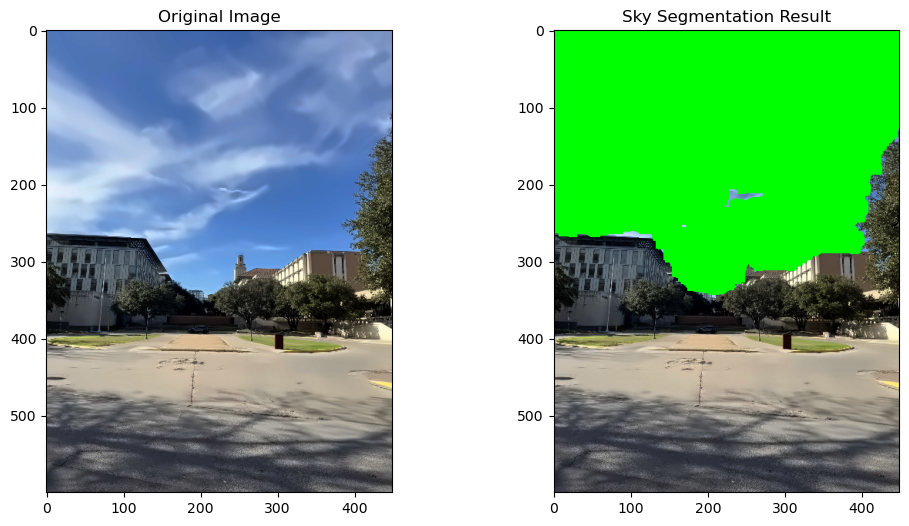

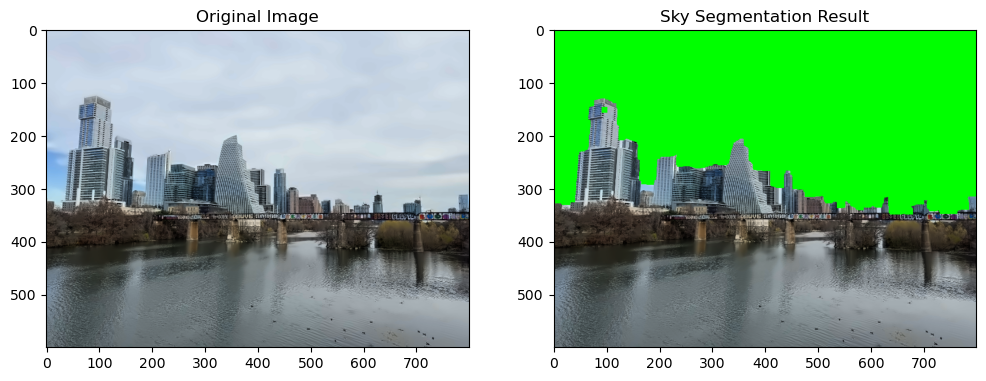

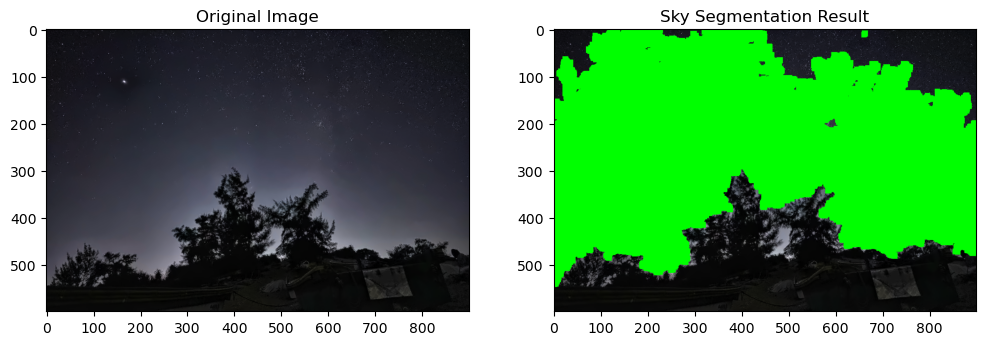

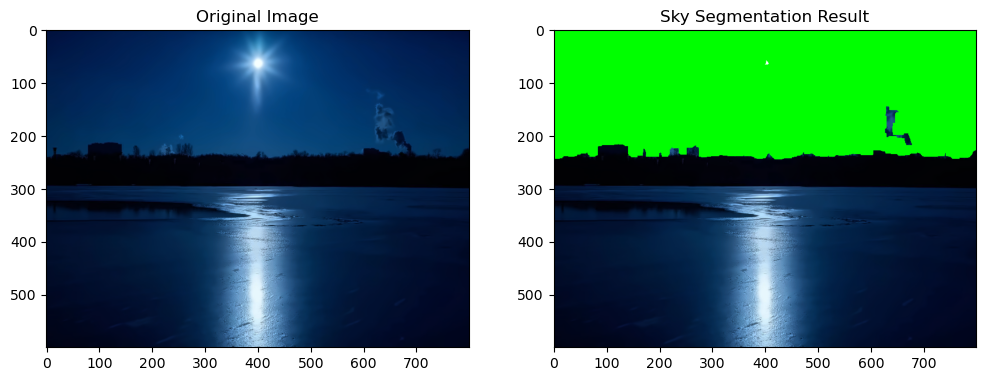

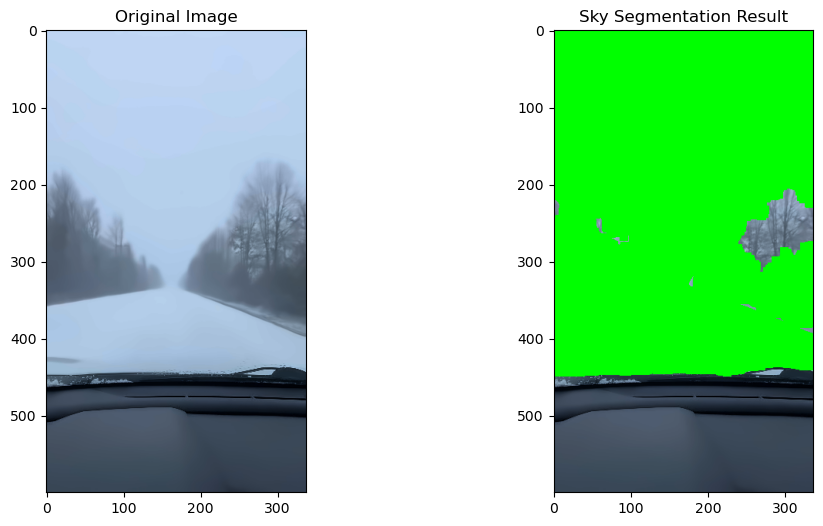

Failed to read image: ./img/.DS_Store


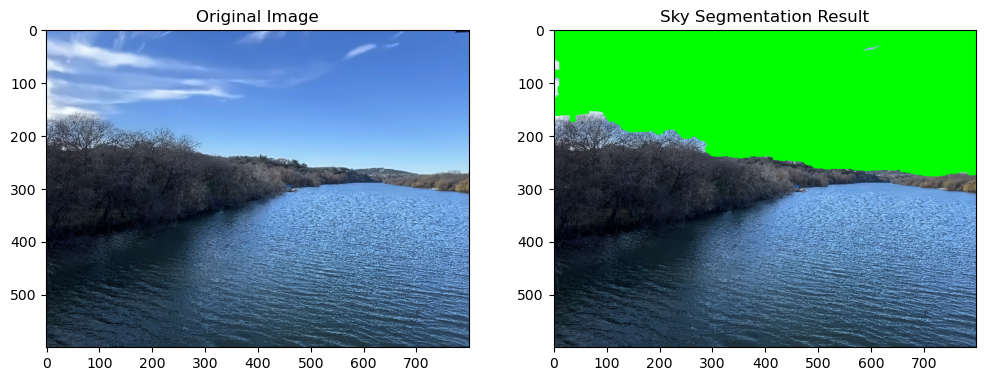

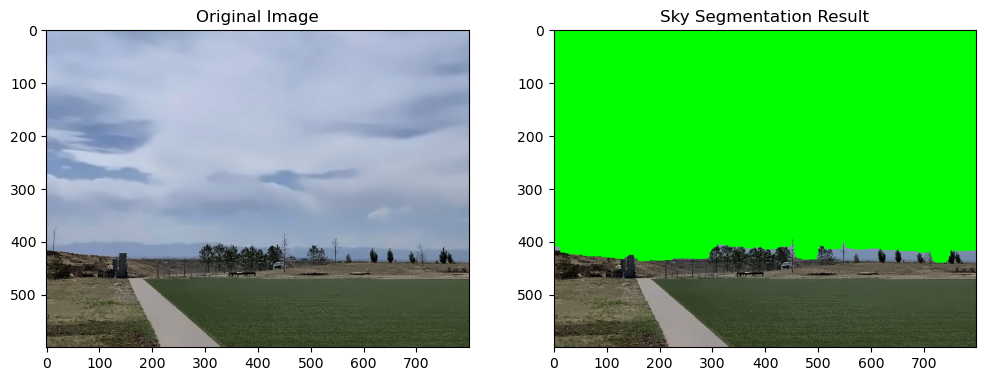

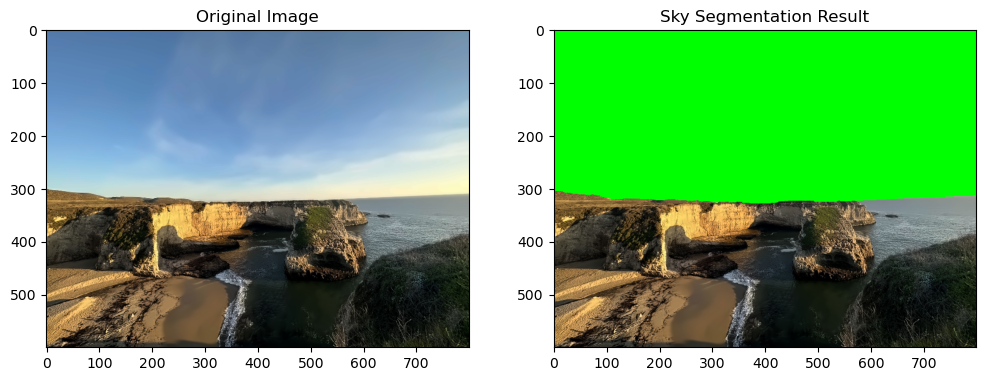

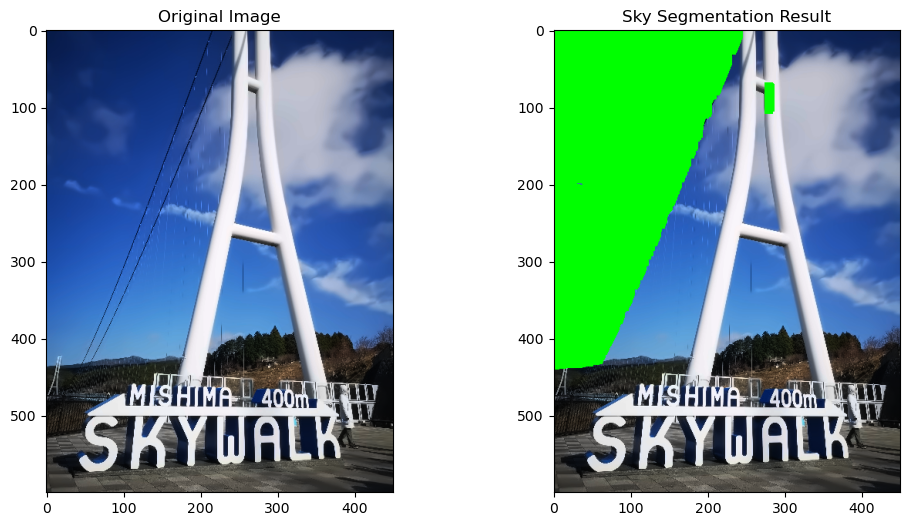

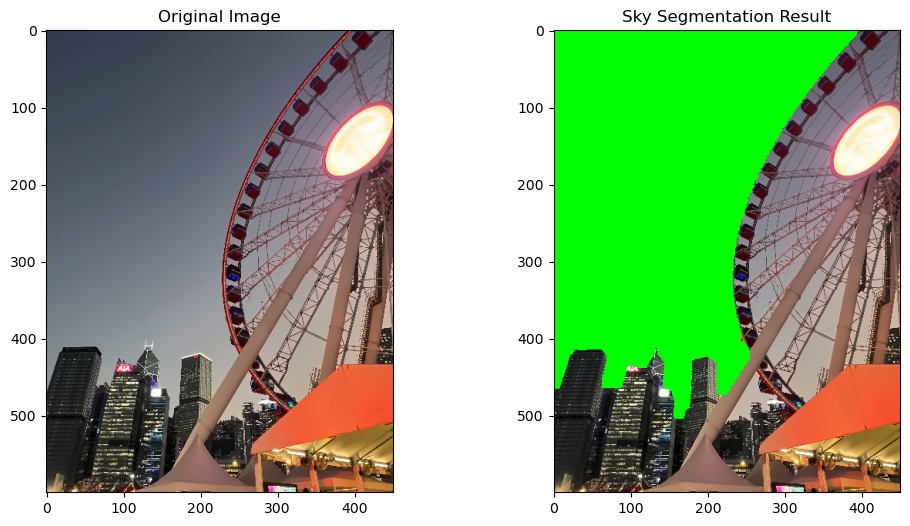

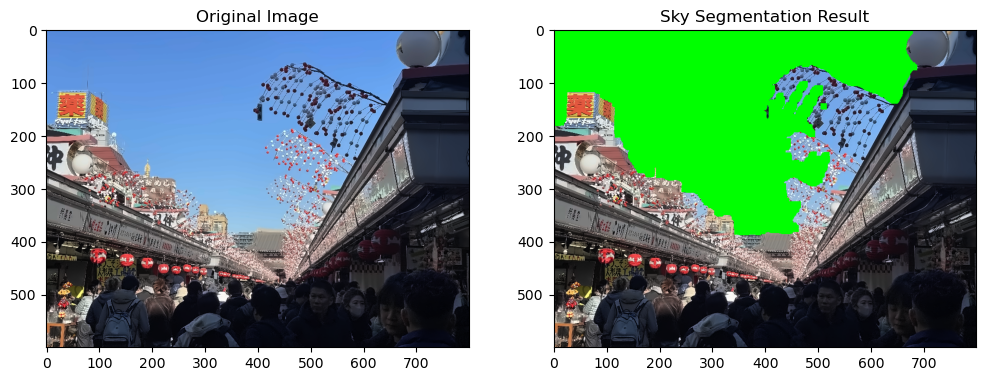

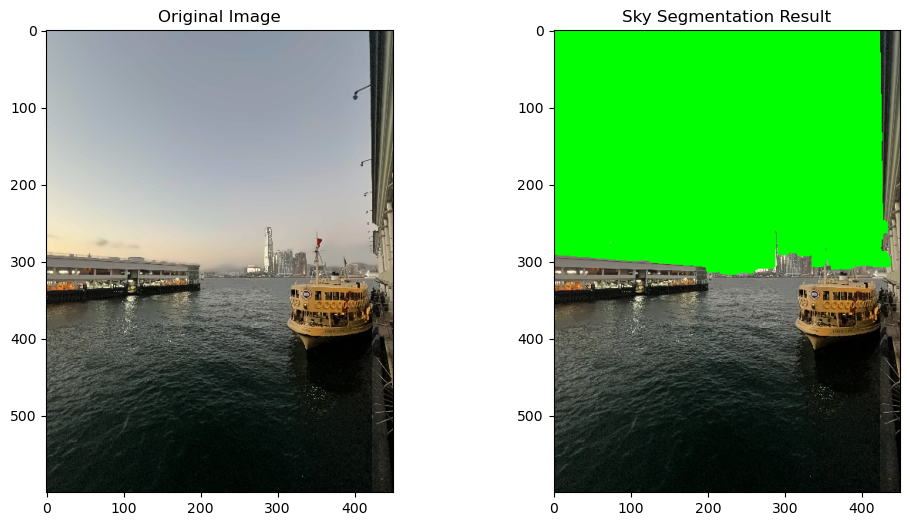

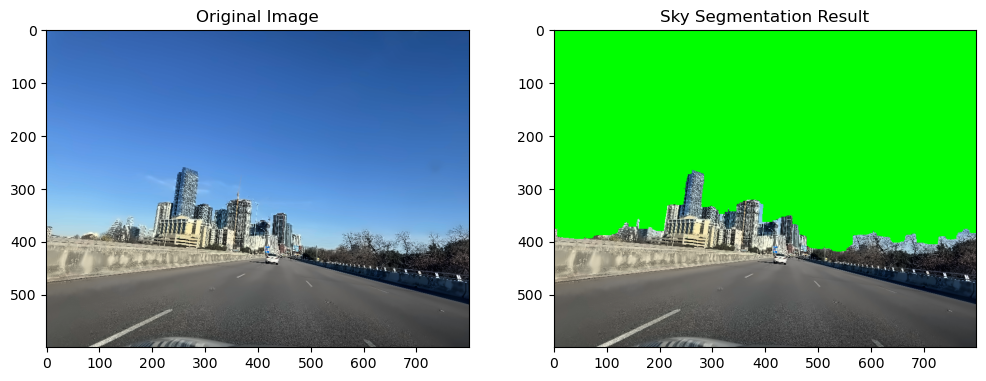

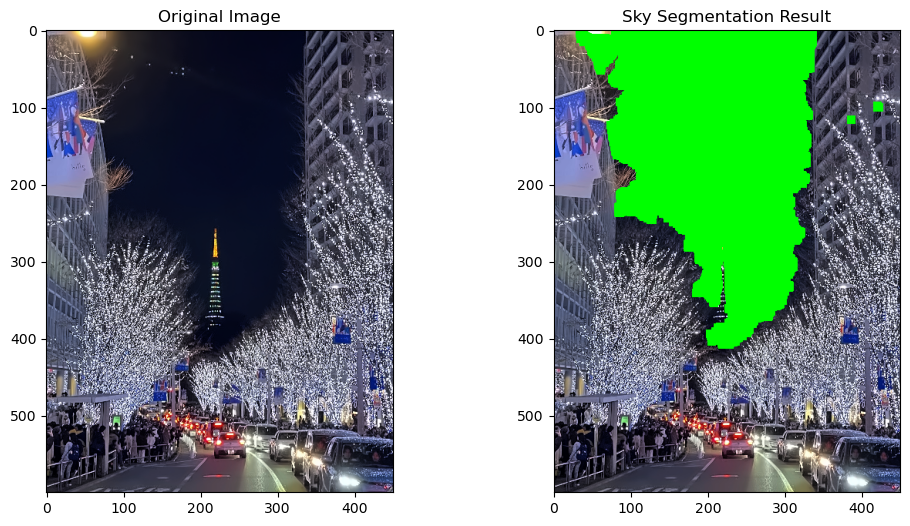

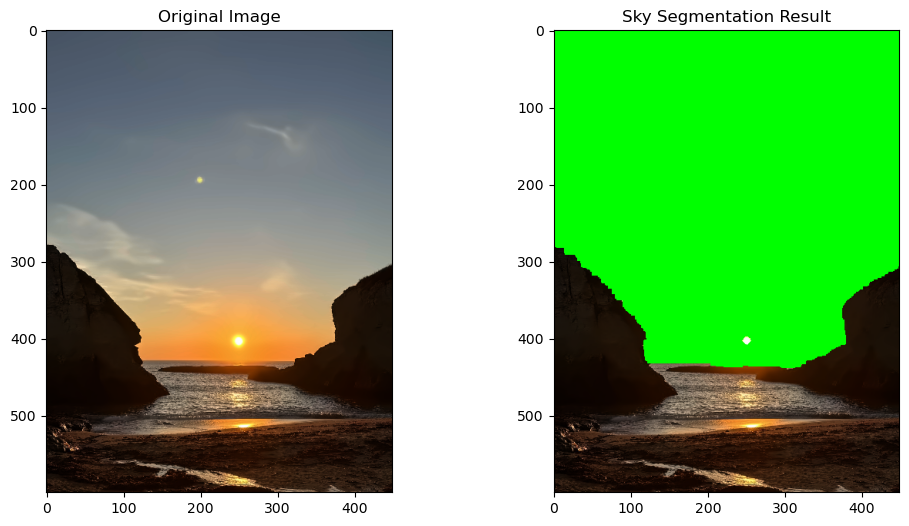

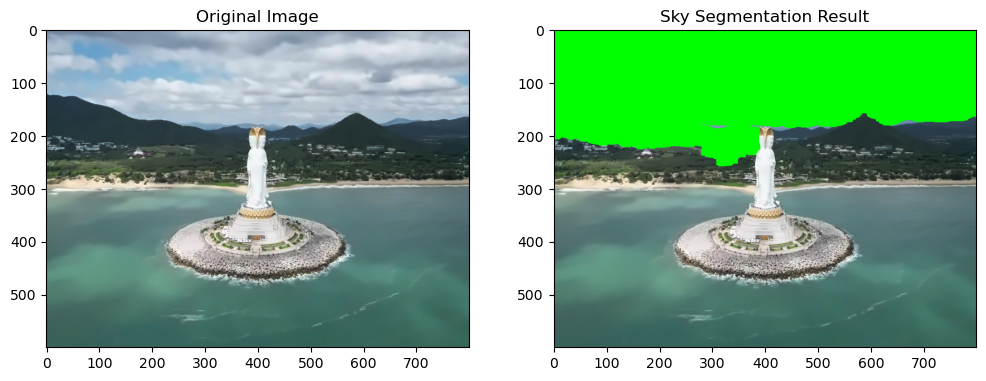

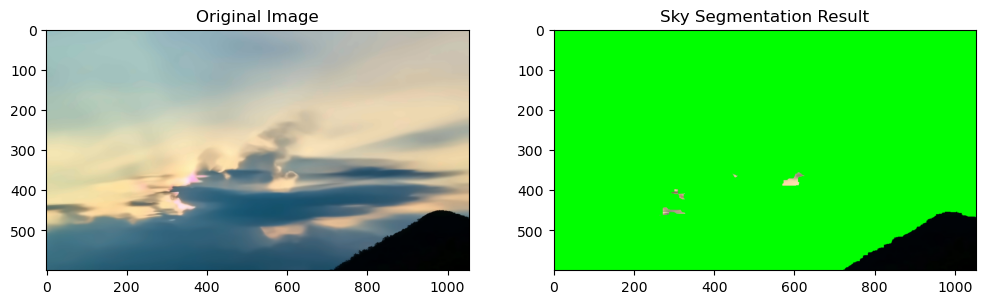

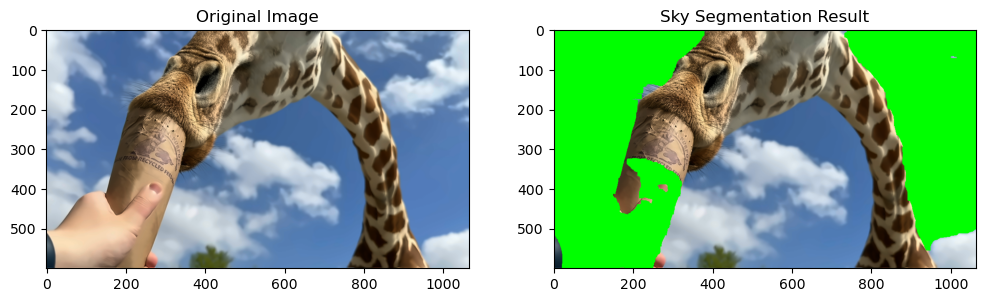

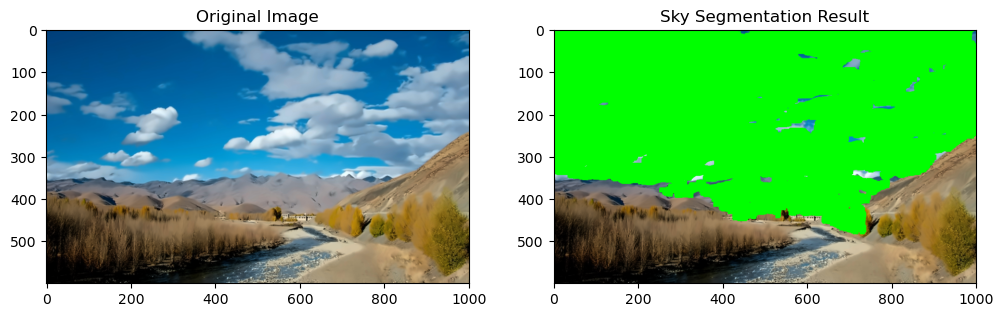

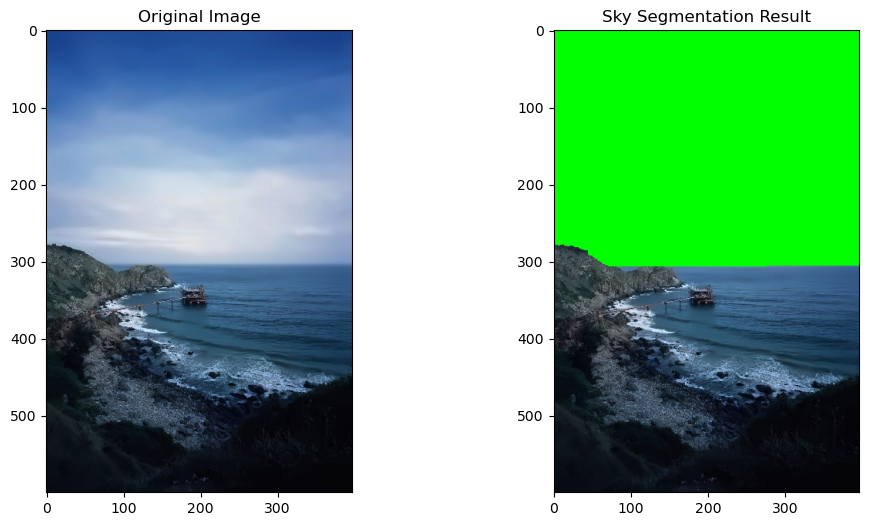

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

def select_seeds_from_blue_area(hsv_image, num_seeds=3):
    """
    Selects seed points from the blue areas of an HSV image. 
    The function return a list of tuples representing the (x, y) coordinates of the seeds.
    """
    # Determine the upper third of the image to focus seed selection
    height, width, _ = hsv_image.shape
    upper_third_height = height // 3

    # Define the HSV range for sky colors
    lower_blue = np.array([90, 10, 10])
    upper_blue = np.array([125, 255, 255])

    # Create a mask that identifies blue areas within the upper third of the image
    blue_mask = cv2.inRange(hsv_image[:upper_third_height, :, :], lower_blue, upper_blue)

    # Randomly selects seed points from the blue areas
    y_indices, x_indices = np.where(blue_mask == 255)
    seeds = []
    if len(x_indices) > num_seeds:
        chosen_indices = random.sample(range(len(x_indices)), num_seeds)
        seeds = [(x_indices[i], y_indices[i]) for i in chosen_indices]

    return seeds

def region_growing(img, seeds, threshold=6):
    """
    Applies the region growing algorithm to segment an image based on similarity.
    The intensity difference threshold is set to 6.
    Function returns a mask of the grown regions.
    """
    # Initialize a mask to track the grown regions
    h, w = img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    # Grow regions from each seed point
    for seed in seeds:
        x, y = seed
        seed_list = [(x, y)]
        while seed_list:
            x, y = seed_list.pop(0)
            if mask[y, x] == 0:  
                mask[y, x] = 255
                # Check and add neighboring pixels based on the threshold
                for nx, ny in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
                    if 0 <= nx < w and 0 <= ny < h:
                        if abs(int(img[ny, nx]) - int(img[y, x])) < threshold:
                            seed_list.append((nx, ny))
    return mask

def image_preprocess(img):
    """
    Preprocesses an image by resizing and denoising it.
    """
    # Resize the image
    ratio = img.shape[1] / img.shape[0]
    width = int(ratio * 600)
    img_resized = cv2.resize(img, (width, 600))

    # Apply denoising
    denoised_image = cv2.fastNlMeansDenoisingColored(img_resized, None, 5, 5, 9, 23)
    
    return denoised_image

def main():
    # Define the path to the images
    folder_path = './img'
    imgs = os.listdir(folder_path)

    for filename in imgs:
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Apply preprocessing steps
            denoised_image = image_preprocess(img)
            hsv_img = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2HSV)
            seeds = select_seeds_from_blue_area(hsv_img)

            if seeds:
                # Convert to grayscale and detect edges for region growing
                img_gray = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
                sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
                sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
                edges = cv2.magnitude(sobelx, sobely)

                # Apply region growing and dilation
                sky_mask = region_growing(edges, seeds)
                kernel = np.ones((11, 11), np.uint8)
                dilated_image = cv2.dilate(sky_mask, kernel, iterations=1)

                # Mark sky regions in green
                output_img = denoised_image.copy()
                output_img[dilated_image == 255] = [0, 255, 0]  

                # Display the original and segmented images
                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
                plt.title('Original Image')
        
                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
                plt.title('Sky Segmentation Result')
                plt.show()
            else:
                print("No suitable seeds found.")
        else:
            print(f"Failed to read image: {img_path}")

if __name__ == "__main__":
    main()
